## 🧪 E1: Threshold 튜닝 실험

> **목표**: 모델 가중치는 그대로 두고, **예측 임계값(threshold)만 조정**하여 오탐(FP) 감소

### 실험 내용
- 기존 학습된 모델 사용 (재학습 X)
- threshold를 0.1~0.9까지 스윕하며 FP, FPR, Precision, Recall, F1 측정
- 최적 threshold 도출

### 변경 사항
- `metric_for_best_model`: f1 (기존 유지)
- `class_weights`: [1, 1] (기존 유지)
- **threshold**: 0.5 → 스윕 (0.1 ~ 0.9)

In [1]:
# ========================================
# 📦 패키지 설치 (필요시)
# ========================================
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q
%pip install transformers==4.42.0 datasets accelerate scikit-learn pandas matplotlib seaborn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# ========================================
# 🔧 경로 설정 (본인 환경에 맞게 수정)
# ========================================
import os

# 절대 경로 사용 (본인 환경에 맞게 수정하세요)
DATA_DIR = r"c:\00_Sookmyunguniv\DACOS(2025)\2학기\프로젝트\github\25-2-team3\data"
OUTPUT_DIR = r"./E1_output"

# 경로 확인
if not os.path.exists(DATA_DIR):
    print(f"⚠️ 데이터 폴더를 찾을 수 없습니다: {DATA_DIR}")
    print(f"   현재 작업 디렉토리: {os.getcwd()}")
else:
    print(f"📂 데이터 폴더: {DATA_DIR}")
print(f"📁 출력 폴더: {OUTPUT_DIR}")

📂 데이터 폴더: c:\00_Sookmyunguniv\DACOS(2025)\2학기\프로젝트\github\25-2-team3\data
📁 출력 폴더: ./E1_output


In [3]:
# ========================================
# 1) 환경 준비
# ========================================
import os
import random
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_recall_fscore_support, accuracy_score, 
                             roc_auc_score, confusion_matrix, classification_report)
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          Trainer, TrainingArguments)

# 시드 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    print(f"✅ GPU 사용 가능: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ GPU가 감지되지 않았습니다. CPU로 실행됩니다.")

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

✅ GPU 사용 가능: NVIDIA GeForce RTX 4060 Ti


In [4]:
# ========================================
# 2) 데이터 로드
# ========================================
abusive_path = os.path.join(DATA_DIR, "combined_abusive_shuffled_20k.csv")
nonabusive_path = os.path.join(DATA_DIR, "nonabusive_merged_shuffled_sample20000.csv")

df_ab = pd.read_csv(abusive_path)[["text", "label"]]
df_non = pd.read_csv(nonabusive_path)[["text", "label"]]

df = pd.concat([df_ab, df_non], ignore_index=True).dropna().reset_index(drop=True)

print(f"📊 라벨 분포:\n{df['label'].value_counts()}")
print(f"\n총 데이터 수: {len(df)}개")

📊 라벨 분포:
label
0    22882
1    17118
Name: count, dtype: int64

총 데이터 수: 40000개


In [5]:
# ========================================
# 3) Train/Test 분리
# ========================================
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 32000, Test: 8000


In [6]:
# ========================================
# 4) 토큰화
# ========================================
MODEL_ID = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

raw_ds = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(test_df),
})

tokenized = raw_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch")

print("✅ 토큰화 완료!")

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

✅ 토큰화 완료!


In [7]:
# ========================================
# 5) 모델 학습 (기존과 동일)
# ========================================
labels_np = train_df["label"].values
pos = (labels_np == 1).sum()
neg = (labels_np == 0).sum()
w0 = 1 / neg
w1 = 1 / pos
scale = 2 / (w0 + w1)
class_weights = torch.tensor([w0 * scale, w1 * scale], dtype=torch.float)
print(f"Class weights: {class_weights}")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    try:
        probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
        auc = roc_auc_score(labels, probs)
    except:
        auc = float("nan")
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

os.makedirs(OUTPUT_DIR, exist_ok=True)

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # 기존 유지
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=50,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = WeightedTrainer(
    model=base_model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("✅ Trainer 설정 완료!")

Class weights: tensor([0.8559, 1.1441])


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Trainer 설정 완료!


In [8]:
# ========================================
# 6) 학습 실행
# ========================================
trainer.train()

  0%|          | 0/3000 [00:00<?, ?it/s]

{'loss': 0.6839, 'grad_norm': 2.425734519958496, 'learning_rate': 4.9e-06, 'epoch': 0.05}
{'loss': 0.5756, 'grad_norm': 4.3658647537231445, 'learning_rate': 9.9e-06, 'epoch': 0.1}
{'loss': 0.4256, 'grad_norm': 4.2172532081604, 'learning_rate': 1.47e-05, 'epoch': 0.15}
{'loss': 0.33, 'grad_norm': 2.977836847305298, 'learning_rate': 1.9699999999999998e-05, 'epoch': 0.2}
{'loss': 0.2531, 'grad_norm': 6.806024551391602, 'learning_rate': 2.47e-05, 'epoch': 0.25}
{'loss': 0.2753, 'grad_norm': 5.396688461303711, 'learning_rate': 2.97e-05, 'epoch': 0.3}
{'loss': 0.2796, 'grad_norm': 3.0265049934387207, 'learning_rate': 2.9477777777777776e-05, 'epoch': 0.35}
{'loss': 0.2442, 'grad_norm': 4.198986530303955, 'learning_rate': 2.8922222222222224e-05, 'epoch': 0.4}
{'loss': 0.2438, 'grad_norm': 6.425168991088867, 'learning_rate': 2.8366666666666667e-05, 'epoch': 0.45}
{'loss': 0.2502, 'grad_norm': 1.1815909147262573, 'learning_rate': 2.781111111111111e-05, 'epoch': 0.5}
{'loss': 0.2291, 'grad_norm':

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.1905481219291687, 'eval_accuracy': 0.92275, 'eval_precision': 0.9190561529271206, 'eval_recall': 0.8986565420560748, 'eval_f1': 0.9087418783225044, 'eval_roc_auc': 0.9789849506874552, 'eval_runtime': 16.0472, 'eval_samples_per_second': 498.529, 'eval_steps_per_second': 15.579, 'epoch': 1.0}
{'loss': 0.14, 'grad_norm': 3.675835371017456, 'learning_rate': 2.1711111111111112e-05, 'epoch': 1.05}
{'loss': 0.1326, 'grad_norm': 3.6549899578094482, 'learning_rate': 2.116666666666667e-05, 'epoch': 1.1}
{'loss': 0.1524, 'grad_norm': 2.2765233516693115, 'learning_rate': 2.0611111111111112e-05, 'epoch': 1.15}
{'loss': 0.1476, 'grad_norm': 6.985886096954346, 'learning_rate': 2.0055555555555556e-05, 'epoch': 1.2}
{'loss': 0.1488, 'grad_norm': 3.094674587249756, 'learning_rate': 1.95e-05, 'epoch': 1.25}
{'loss': 0.1359, 'grad_norm': 4.245350360870361, 'learning_rate': 1.8944444444444447e-05, 'epoch': 1.3}
{'loss': 0.145, 'grad_norm': 1.7562111616134644, 'learning_rate': 1.838888888888

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.20958544313907623, 'eval_accuracy': 0.92825, 'eval_precision': 0.9320800485142511, 'eval_recall': 0.8977803738317757, 'eval_f1': 0.9146087473966081, 'eval_roc_auc': 0.9809351078973597, 'eval_runtime': 16.1864, 'eval_samples_per_second': 494.241, 'eval_steps_per_second': 15.445, 'epoch': 2.0}
{'loss': 0.0682, 'grad_norm': 4.678597927093506, 'learning_rate': 1.0611111111111111e-05, 'epoch': 2.05}
{'loss': 0.0723, 'grad_norm': 6.029900074005127, 'learning_rate': 1.0055555555555557e-05, 'epoch': 2.1}
{'loss': 0.0735, 'grad_norm': 2.24930477142334, 'learning_rate': 9.5e-06, 'epoch': 2.15}
{'loss': 0.0812, 'grad_norm': 3.4027059078216553, 'learning_rate': 8.944444444444444e-06, 'epoch': 2.2}
{'loss': 0.0845, 'grad_norm': 6.12247371673584, 'learning_rate': 8.388888888888888e-06, 'epoch': 2.25}
{'loss': 0.065, 'grad_norm': 12.429498672485352, 'learning_rate': 7.833333333333333e-06, 'epoch': 2.3}
{'loss': 0.0599, 'grad_norm': 1.7471266984939575, 'learning_rate': 7.27777777777777

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.28701451420783997, 'eval_accuracy': 0.927375, 'eval_precision': 0.9321982365460626, 'eval_recall': 0.8954439252336449, 'eval_f1': 0.913451511991658, 'eval_roc_auc': 0.9806868666161526, 'eval_runtime': 16.5015, 'eval_samples_per_second': 484.804, 'eval_steps_per_second': 15.15, 'epoch': 3.0}
{'train_runtime': 959.6142, 'train_samples_per_second': 100.04, 'train_steps_per_second': 3.126, 'train_loss': 0.1650975329875946, 'epoch': 3.0}


TrainOutput(global_step=3000, training_loss=0.1650975329875946, metrics={'train_runtime': 959.6142, 'train_samples_per_second': 100.04, 'train_steps_per_second': 3.126, 'total_flos': 6314665328640000.0, 'train_loss': 0.1650975329875946, 'epoch': 3.0})

In [9]:
# ========================================
# 🎯 7) Threshold 스윕 실험 (핵심!)
# ========================================
print("\n" + "="*60)
print("🎯 Threshold 스윕 실험")
print("="*60)

# Validation 데이터로 logits 추출
predictions = trainer.predict(tokenized["validation"])
logits = predictions.predictions
labels = predictions.label_ids

# softmax로 확률 변환
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]

# Threshold 스윕
thresholds = np.arange(0.1, 1.0, 0.05)
results = []

for th in thresholds:
    preds = (probs >= th).astype(int)
    
    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    
    # 지표 계산
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    
    results.append({
        "threshold": th,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "FPR": fpr,
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


🎯 Threshold 스윕 실험


  0%|          | 0/250 [00:00<?, ?it/s]

 threshold   TP  FP   TN  FN  Precision   Recall       F1      FPR
      0.10 3247 501 4075 177   0.866329 0.948306 0.905466 0.109484
      0.15 3222 433 4143 202   0.881532 0.941005 0.910298 0.094624
      0.20 3196 384 4192 228   0.892737 0.933411 0.912621 0.083916
      0.25 3173 340 4236 251   0.903217 0.926694 0.914805 0.074301
      0.30 3151 309 4267 273   0.910694 0.920269 0.915456 0.067526
      0.35 3124 281 4295 300   0.917474 0.912383 0.914922 0.061407
      0.40 3106 262 4314 318   0.922209 0.907126 0.914605 0.057255
      0.45 3091 239 4337 333   0.928228 0.902745 0.915309 0.052229
      0.50 3074 224 4352 350   0.932080 0.897780 0.914609 0.048951
      0.55 3053 213 4363 371   0.934783 0.891647 0.912706 0.046547
      0.60 3037 193 4383 387   0.940248 0.886974 0.912834 0.042177
      0.65 3013 175 4401 411   0.945107 0.879965 0.911373 0.038243
      0.70 2991 160 4416 433   0.949222 0.873540 0.909810 0.034965
      0.75 2957 144 4432 467   0.953563 0.863610 0.906360 0.03

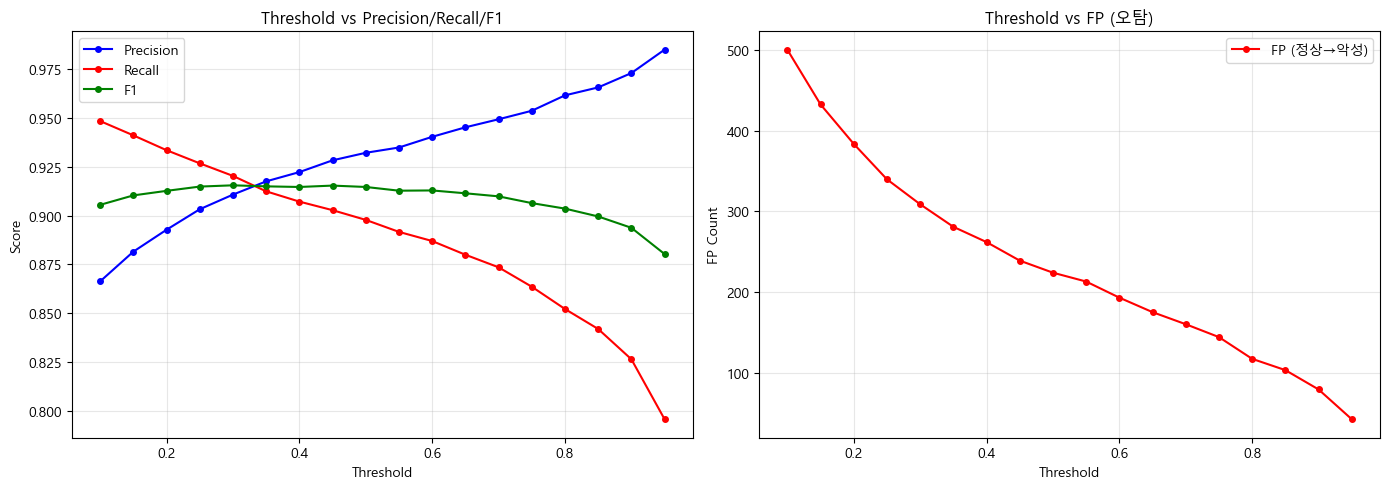

In [10]:
# ========================================
# 📊 8) 시각화: Threshold vs 지표
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision, Recall, F1
ax1 = axes[0]
ax1.plot(results_df['threshold'], results_df['Precision'], 'b-o', label='Precision', markersize=4)
ax1.plot(results_df['threshold'], results_df['Recall'], 'r-o', label='Recall', markersize=4)
ax1.plot(results_df['threshold'], results_df['F1'], 'g-o', label='F1', markersize=4)
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Threshold vs Precision/Recall/F1')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: FP 개수, FPR
ax2 = axes[1]
ax2.plot(results_df['threshold'], results_df['FP'], 'r-o', label='FP (정상→악성)', markersize=4)
ax2.set_xlabel('Threshold')
ax2.set_ylabel('FP Count')
ax2.set_title('Threshold vs FP (오탐)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'E1_threshold_sweep.png'), dpi=150)
plt.show()

In [11]:
# ========================================
# 🏆 9) 최적 Threshold 선택
# ========================================
# 기준 1: F1 최대화
best_f1_idx = results_df['F1'].idxmax()
best_f1_row = results_df.iloc[best_f1_idx]

# 기준 2: FP 최소화 (Recall 0.8 이상 유지)
filtered = results_df[results_df['Recall'] >= 0.8]
if len(filtered) > 0:
    best_fp_idx = filtered['FP'].idxmin()
    best_fp_row = filtered.iloc[filtered['FP'].values.argmin()]
else:
    best_fp_row = None

print("\n" + "="*60)
print("🏆 최적 Threshold 추천")
print("="*60)
print(f"\n[F1 최대화 기준]")
print(f"  Threshold: {best_f1_row['threshold']:.2f}")
print(f"  F1: {best_f1_row['F1']:.4f}, Precision: {best_f1_row['Precision']:.4f}, Recall: {best_f1_row['Recall']:.4f}")
print(f"  FP: {best_f1_row['FP']}, FPR: {best_f1_row['FPR']:.4f}")

if best_fp_row is not None:
    print(f"\n[FP 최소화 기준 (Recall≥0.8)]")
    print(f"  Threshold: {best_fp_row['threshold']:.2f}")
    print(f"  F1: {best_fp_row['F1']:.4f}, Precision: {best_fp_row['Precision']:.4f}, Recall: {best_fp_row['Recall']:.4f}")
    print(f"  FP: {best_fp_row['FP']}, FPR: {best_fp_row['FPR']:.4f}")


🏆 최적 Threshold 추천

[F1 최대화 기준]
  Threshold: 0.30
  F1: 0.9155, Precision: 0.9107, Recall: 0.9203
  FP: 309.0, FPR: 0.0675

[FP 최소화 기준 (Recall≥0.8)]
  Threshold: 0.90
  F1: 0.8937, Precision: 0.9728, Recall: 0.8265
  FP: 79.0, FPR: 0.0173


In [13]:
# ========================================
# 📝 10) 실험 결과 기록
# ========================================
print("\n" + "="*60)
print("📝 실험 결과 기록 (복사용)")
print("="*60)

best_fp_th = f"{best_fp_row['threshold']:.2f}" if best_fp_row is not None else 'N/A'
best_fp_th_recommend = f"{best_fp_row['threshold']:.2f}" if best_fp_row is not None else '0.7'
print(f"""
#### 실험 ID: E1
- 변경 사항:
  - threshold 스윕 (0.1 ~ 0.95)
  - 최적 threshold (F1 기준): {best_f1_row['threshold']:.2f}
  - 최적 threshold (FP 최소, Recall≥0.8): {best_fp_th}
- 데이터:
  - train/validation split: 0.8/0.2 (random_state=42, stratify=label)
  - max_length=128, batch_size=32, epochs=3
- Validation 성능 (threshold={best_f1_row['threshold']:.2f}):
  - FP(정상→악성): {best_f1_row['FP']}
  - FPR: {best_f1_row['FPR']:.4f}
  - Precision: {best_f1_row['Precision']:.4f}
  - Recall: {best_f1_row['Recall']:.4f}
  - F1: {best_f1_row['F1']:.4f}
- 코멘트:
  - threshold 올릴수록 FP 감소, 대신 Recall 하락
  - 운영 시 {best_fp_th_recommend} 이상 권장 (FP 감소)
""")


📝 실험 결과 기록 (복사용)

#### 실험 ID: E1
- 변경 사항:
  - threshold 스윕 (0.1 ~ 0.95)
  - 최적 threshold (F1 기준): 0.30
  - 최적 threshold (FP 최소, Recall≥0.8): 0.90
- 데이터:
  - train/validation split: 0.8/0.2 (random_state=42, stratify=label)
  - max_length=128, batch_size=32, epochs=3
- Validation 성능 (threshold=0.30):
  - FP(정상→악성): 309.0
  - FPR: 0.0675
  - Precision: 0.9107
  - Recall: 0.9203
  - F1: 0.9155
- 코멘트:
  - threshold 올릴수록 FP 감소, 대신 Recall 하락
  - 운영 시 0.90 이상 권장 (FP 감소)



In [14]:
# ========================================
# 💾 11) 모델 저장
# ========================================
SAVE_DIR = os.path.join(OUTPUT_DIR, "best_model")
os.makedirs(SAVE_DIR, exist_ok=True)
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

# 결과 CSV 저장
results_df.to_csv(os.path.join(OUTPUT_DIR, "threshold_sweep_results.csv"), index=False)

print(f"✅ 모델 저장 완료: {SAVE_DIR}")
print(f"✅ 결과 CSV 저장 완료: {OUTPUT_DIR}/threshold_sweep_results.csv")

✅ 모델 저장 완료: ./E1_output\best_model
✅ 결과 CSV 저장 완료: ./E1_output/threshold_sweep_results.csv
